# 4.태깅 작업(Tagging Task)

여기서는 자연어 처리 분야에서 각 단어가 어떤 유형에 속해있는지를 알아내는 태깅 작업에 대해서 배웁니다. 이러한 단어 태깅 작업은 대표적으로 크게 두 가지가 있는데 각 단어의 유형이 사람, 장소, 단체 등 어떤 유형인지를 알아내는 개체명 인식(Named Entity Recognition)과 각 단어의 품사가 명사, 동사, 형용사 인지를 알아내는 품사 태깅(Part-of-Speech Tagging)이 있습니다.

이러한 작업은 챗봇, 기계 번역 등과 같은 자연어 처리 분야에서 메인 작업에 앞서 전처리 작업으로서 필요한 경우가 많지만, 전처리 작업이라고 쉬운 작업이 아니라 그 자체로도 까다로운 작업이 되어 많은 시간을 필요로 하는 작업이 되기도 합니다.

여기서는 케라스(Keras)를 이용해서 인공 신경망을 이용한 개체명 인식기와 품사 태거를 만드는 간단한 미니 프로젝트를 수행해보도록 하겠습니다.

## 1) 케라스를 이용한 태깅 작업 개요(Tagging Task using Keras)

이번 챕터에서는 케라스(Keras)로 인공 신경망을 이용하여 태깅 작업을 하는 모델을 만듭니다. 개체명 인식기와 품사 태거를 만드는데, 이러한 두 작업의 공통점은 RNN의 다-대-다(Many-to-Many) 작업이면서 또한 앞, 뒤 시점의 입력을 모두 참고하는 양방향 RNN(Bidirectional RNN)을 사용한다는 점입니다.

두 개의 실습 챕터를 진행하기 전에 전체적으로 실습이 어떻게 진행되는지 정리해보도록 하겠습니다. 텍스트 분류 개요 챕터와 겹치는 부분에 대해서는 요약하여 설명하므로, 이해가 되지 않는 부분이 있다면 해당 챕터를 참고바랍니다.

### 1. 훈련 데이터에 대한 이해

태깅 작업은 앞서 배운 텍스트 분류 작업과 동일하게 지도 학습(Supervised Learning)에 속합니다. 이 챕터에서는 태깅을 해야하는 단어 데이터를 X, 레이블에 해당되는 태깅 정보 데이터는 y라고 이름을 붙였습니다. X에 대한 훈련 데이터는 X_train, 테스트 데이터는 X_test라고 명명하고 y에 대한 훈련 데이터는 y_train, 테스트 데이터는 y_test라고 명명합니다.

이번 챕터에서 X와 y데이터의 쌍(pair)은 병렬 구조를 가진다는 특징을 가집니다. X와 y의 각 데이터의 길이는 같습니다. 예를 들어 품사 태깅 작업을 한다고 가정해보겠습니다. 그리고 X_train와 y_train의 데이터 중 4개의 데이터만 확인해본다고 가정해보겠습니다. 이 때 데이터는 다음과 같은 구조를 가집니다.


|X_train|y_train|길이|
|--------|----------|---------|
|0|['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb']|['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O']|8|
|1|['peter', 'blackburn']|['B-PER', 'I-PER']|2|
|2|['brussels', '1996-08-22' ]|['B-LOC', 'O']|2|
|3|['The', 'European', 'Commission']|['O', 'B-ORG', 'I-ORG']|3|

가령, X_train[3]의 'The'와 y_train[3]의 'O'는 하나의 쌍(pair)입니다. 또한, X_train[3]의 'European'과 y_train[3]의 'B-ORG'는 쌍의 관계를 가지며, X_train[3]의 'Commision'과 y_train[3]의 'I-ORG'는 쌍의 관계를 가집니다.

이렇게 병렬 관계를 가지는 각 데이터는 정수 인코딩 과정을 거친 후, 모든 데이터의 길이를 동일하게 맞춰주기위한 패딩(Padding) 작업을 거칩니다.

### 2. 시퀀스 레이블링(Sequence Labeling)

위와 같이 입력 시퀀스 X = [x1, x2, x3, ..., xn]에 대하여 레이블 시퀀스 y = [y1, y2, y3, ..., yn]를 각각 부여하는 작업을 시퀀스 레이블링 작업(Sequence Labeling Task)이라고 합니다. 태깅 작업은 대표적인 시퀀스 레이블링 작업입니다.

### 3. 양방향 LSTM(Bidirectional LSTM)

model.add(Bidirectional(LSTM(hidden_size, return_sequences=True)))

이번 챕터에서도 바닐라 RNN이 아니라 성능이 개선된 RNN인 LSTM을 사용합니다. 텍스트 분류 챕터에서는 단방향 LSTM을 사용하였지만, 이번 챕터에서는 양방향 LSTM을 사용합니다. 이전 시점의 단어 정보 뿐만 아니라, 다음 시점의 단어 정보도 참고하기 위함입니다. 양방향은 기존의 단방향 LSTM()을 Bidirectional() 안에 넣으면 됩니다.

인자 정보는 단방향 LSTM을 사용할 때와 동일합니다. 즉, 인자값을 하나를 줄 경우에는 이는 hidden_size를 의미하며, 결과적으로 output_dim이 됩니다.

### 4. RNN의 다-대-다(Many-to-Many) 문제

![](img/many_to_one.png)

RNN의 은닉층은 모든 시점에 대해서 은닉 상태값을 출력할 수 있고, 마지막 시점에 대해서만 은닉 상태값을 출력할 수 있습니다. 이는 인자로 return_sequences=True를 넣을 것인지, 넣지 않을 것인지로 설정할 수 있는데 태깅 작업의 경우에는 다-대-다(Many-to-Many) 문제로 return_sequences=True를 설정하여 출력층에 모든 은닉 상태값을 보냅니다.

이제 RNN이 어떻게 설계되는지 확인해보도록 하겠습니다. 예를 들어 위에서 설명한 데이터 중 첫번째 데이터에 해당되는 X_train[0]를 가지고 4번의 시점(time steps)까지 RNN을 진행하였을 때의 그림은 다음과 같습니다.

![](img/forwardrnn_ver2.png)

하지만 이번 실습에서는 양방향 RNN을 사용할 것이므로 아래의 그림과 같습니다.

![](img/bidirectionalrnn_ver2.png)

## 2) 개체명 인식(Named Entity Recognition)

이번 챕터에서는 코퍼스로부터 각 개체(entity)의 유형을 인식하는 개체명 인식(Named Entity Recognition)에 대해서 배웁니다. 개체명 인식을 사용하면 코퍼스로부터 어떤 단어가 사람, 장소, 조직 등을 의미하는 단어인지를 찾을 수 있습니다.

### 1. 개체명 인식(Named Entity Recognition)이란?

개체명 인식(Named Entity Recognition)이란 말 그대로 이름을 가진 개체(named entity)를 인식하겠다는 것을 의미합니다. 좀 더 쉽게 설명하면, 어떤 이름을 의미하는 단어를 보고는 그 단어가 어떤 유형인지를 인식하는 것을 말합니다.

예를 들어 도연이는 2018년에 골드만삭스에 입사했다. 라는 문장이 있을 때, 사람(person), 조직(organization), 시간(time)에 대해 개체명 인식을 수행하는 모델이라면 다음과 같은 결과를 보여줍니다.

**도연 - 사람  
2018년 - 시간  
골드만삭스 - 조직**

여기서는 우선 개체명 인식의 정의부터 이해하기 위해 중간 과정을 생략했지만 개체명 인식 모델이 개체명을 인식하기 위해서는 보통 전처리 과정이 필요합니다. 개체명 모델에 따라서는 품사 정보(POS Tagging, Part-Of-Speech Tagging)를 입력으로 요구하기도 합니다.

예제를 통해 개체명 인식을 이해해보도록 하겠습니다.

### 2. NLTK를 이용한 개체명 인식(Named Entity Recognition using NTLK)

NLTK에서는 개체명 인식기(NER chunker)를 지원하고 있으므로, 별도 개체명 인식기를 구현할 필요없이 NLTK를 사용해서 개체명 인식을 수행할 수 있습니다. 만약 아래의 실습에서 nltk.download('maxent_ne_chunker'), nltk.download('words') 등의 설치를 요구하는 에러 문구가 뜬다면, 지시하는대로 설치하면 됩니다.

In [1]:
from nltk import word_tokenize, pos_tag, ne_chunk
sentence = "James is working at Disney in London"
sentence=pos_tag(word_tokenize(sentence))
print(sentence) # 토큰화와 품사 태깅을 동시 수행

[('James', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('Disney', 'NNP'), ('in', 'IN'), ('London', 'NNP')]


In [2]:
sentence=ne_chunk(sentence)
print(sentence) # 개체명 인식

(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


ne_chunk는 개체명을 태깅하기 위해서 앞서 품사 태깅(pos_tag)이 수행되어야 합니다. 위의 결과에서 James는 PERSON(사람), Disney는 조직(ORGANIZATION), London은 위치(GPE)라고 정상적으로 개체명 인식이 수행된 것을 볼 수 있습니다.

이번 챕터에서는 인공 신경망을 이용해서 개체명 인식 모델을 만들어보겠습니다.

### 3) 양방향 LSTM을 이용한 개체명 인식(Named Entity Recognition using Bi-LSTM)

개체명 인식은 챗봇 등에서 필요로 하는 주요 전처리 작업이지만, 그 자체로도 까다로운 작업이기도 합니다. 도메인 또는 목적에 특화되도록 개체명 인식을 정확하게 하는 방법 중 하나는 기존에 공개된 개체명 인식기를 사용하는 것이 아니라, 직접 목적에 맞는 데이터를 준비하여 기계를 훈련시켜 모델을 만드는 방법입니다. 여기서는 양방향 LSTM을 이용해서 개체명 인식기를 만들어봅니다.

### 1. BIO 표현

개체명 인식에서 코퍼스로부터 개체명을 인식하기 위한 방법으로는 여러 방법이 있지만, 여기서는 가장 보편적인 방법 중 하나인 IOB (또는 BIO) 방법을 소개합니다. B는 Begin의 약자로 개체명이 시작되는 부분, I는 Inside의 약자로 개체명의 내부 부분을 의미하며, O는 Outside의 약자로 개체명이 아닌 부분을 의미합니다.

예를 들어서 영화에 대한 코퍼스 중에서 영화 제목에 대한 개체명을 뽑아내고 싶다고 가정합시다.

**해 B  
리 I  
포 I  
터 I  
보 O  
러 O  
가 O  
자 O**  

다음과 같이 영화 제목에 대해서만 개체명을 인식하는데, 영화 제목이 시작되는 글자인 '해'에서는 B가 사용되었고, 그리고 영화 제목이 끝나는 순간까지 I가 사용됩니다. 그리고 영화 제목이 아닌 부분에 대해서만 O가 사용됩니다. 이처럼 B와 I는 개체명을 위해 사용되고, O는 개체명이 아니라는 의미를 갖게 됩니다.

물론 개체명 인식이라는 것은 보통 한 종류의 개체에 대해서만 언급하는 것이 아니라, 여러 종류의 개체가 있을 수 있습니다. 예를 들어 영화에 대한 대화에서는 영화 제목에 대한 개체명과 극장에 대한 개체명이 있을 수 있습니다. 그럴 때는, 각 개체가 어떤 종류인지도 함께 태깅이 될 것입니다.

해 B-movie  
리 I-movie  
포 I-movie  
터 I-movie  
보 O  
러 O  
메 B-theater  
가 I-theater  
박 I-theater  
스 I-theater  
가 O  
자 O  

### 2. 개체명 인식 데이터 이해하기

이제 실습을 통해 양방향 LSTM을 이용한 개체명 인식에 대해서 더 자세히 알아보도록 하겠습니다. CONLL2003은 개체명 인식을 위한 전통적인 영어 데이터 셋입니다. 해당 데이터를 가지고 훈련하여 개체명 인식 모델을 만들어보겠습니다.

다운로드 링크 : https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt
전체 데이터는 위 링크에서 train.txt 파일을 다운로드 받을 수 있습니다.

해당 데이터의 앞 부분을 일부 보겠습니다.

EU NNP B-NP B-ORG  
rejects VBZ B-VP O  
German JJ B-NP B-MISC  
call NN I-NP O  
to TO B-VP O  
boycott VB I-VP O  
British JJ B-NP B-MISC  
lamb NN I-NP O  
. . O O  
  
Peter NNP B-NP B-PER  
Blackburn NNP I-NP I-PER  

데이터의 형식은 [단어] [품사 태깅] [청크 태깅] [개체명 태깅]의 형식으로 되어있습니다.

품사 태깅이 의미하는 바는 아래 링크에서 자세하게 확인할 수 있는데, 예를 들어서 EU 옆에 붙어있는 NNP는 고유 명사 단수형을 의미하며, rejects 옆에 있는 VBZ는 3인칭 단수 동사 현재형을 의미합니다.
https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

개체명 태깅의 경우에는 LOC는 location, ORG는 organization, PER은 person, MISC는 miscellaneous를 의미합니다. 해당 데이터는 BIO 표현 방법을 사용하고 있기 때문에, 개체명의 시작 부분이면서 Organization을 의미하는 German에는 B-ORG라는 개체명 태깅이 붙습니다. 다만, German 그 자체로 개체명 하나이기 때문에 거기서 개체명 인식은 종료되면서 뒤에 I가 별도로 붙는 단어가 나오지는 않았습니다. 이에 German 뒤에 나오는 call은 개체명이 아니기 때문에 O가 태깅이 됩니다.

또 하나 기억해두어야할 것은 9번째 줄인. . O O 다음에 11번째 줄 Peter가 나오는 부분 사이에서 10번째 줄은 공란으로 되어 있는데, 이는 9번째 줄에서 문장이 끝나고 11번째 줄에서 새로운 문장이 시작됨을 의미합니다.

그 다음 문장이 시작되는 11번째 줄에서는 개체명이 하나의 단어로 끝나지 않았을 때, 어떻게 다음 단어로 개체명 인식이 이어지는지를 보여줍니다. Peter는 개체명이 시작되면서 person에 해당되기 때문에 B-PER이라는 개체명 태깅이 붙습니다. 그리고 아직 개체명에 대한 인식은 끝나지 않았기 때문에 뒤에 붙는 Blackburn에서는 I가 나오면서 I-PER이 개체명 태깅으로 붙게 됩니다. 즉, Peter Blackburn이 person에 속하는 하나의 개체명입니다.

### 3. 데이터 전처리하기

이번에는 양방향 LSTM을 이용해서 개체명 인식 태깅을 하는 모델을 만들어보겠습니다.

In [2]:
import re
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

위에서 설명한 개체명 인식 데이터를 읽어 전처리를 수행합니다.

In [3]:
f = open('train.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.

전체 샘플 개수를 확인해보겠습니다.

In [4]:
print("전체 샘플 개수: ", len(tagged_sentences)) # 전체 샘플의 개수 출력

전체 샘플 개수:  14041


이 중 첫번째 샘플만 출력해보겠습니다.

In [5]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


전처리가 수행된 첫번째 샘플이 출력된 것을 볼 수 있습니다. 이러한 샘플이 총 14,041개가 있습니다. 그런데 훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 개체명 태깅 정보에 해당되는 부분을 분리시켜야 합니다. 즉, [('eu', 'B-ORG'), ('rejects', 'O')]와 같은 문장 샘플이 있다면 eu와 rejects는 같이 저장하고, B-ORG와 O를 같이 저장할 필요가 있습니다.

이런 경우 파이썬 함수 중에서 zip()함수가 유용한 역할을 합니다. zip()함수는 동일한 개수를 가지는 시퀀스 자료형에서 각 순서에 등장하는 원소들끼리 묶어주는 역할을 합니다. (2챕터의 데이터의 분리 챕터 참고)

In [6]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 14,041개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

각 문장 샘플에 대해서 단어는 sentences에 태깅 정보는 ner_tags에 저장하였습니다. 임의로 첫번째 문장 샘플을 출력해보겠습니다.

In [7]:
print(sentences[0])
print(ner_tags[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


첫번째 샘플에 대해서 단어에 대해서만 sentences[0]에, 또한 개체명에 대해서만 ner_tags[0]에 저장된 것을 볼 수 있습니다. 뒤에서 보겠지만, sentences는 예측을 위한 X에 해당되며 ner_tags는 예측 대상인 y에 해당됩니다. 다른 샘플들에 대해서도 처리가 되었는지 확인하기 위해 임의로 13번째 샘플에 대해서도 확인해보겠습니다.

In [8]:
print(sentences[12])
print(ner_tags[12])

['only', 'france', 'and', 'britain', 'backed', 'fischler', "'s", 'proposal', '.']
['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']


단어에 대해서만 sentences[12]에, 또한 개체명에 대해서만 ner_tags[12]에 저장된 것을 확인할 수 있습니다. 또한 첫번째 샘플과 길이가 다른 것을 볼 수 있습니다. 사실 14,041개의 문장 샘플의 길이는 전부 제각각입니다. 전체 데이터의 길이 분포를 확인해봅시다.

샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.501887


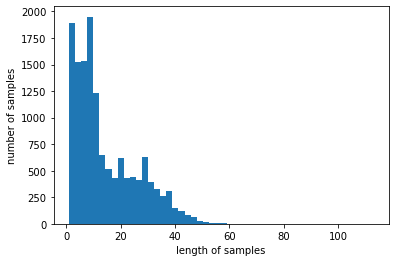

In [9]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프는 샘플들의 길이가 대체적으로 0~40의 길이를 가지며, 특히 0~20의 길이를 가진 샘플이 상당한 비율을 차지하는 것을 보여줍니다. 길이가 가장 긴 샘플의 길이는 113입니다. 이제 케라스 토크나이저를 통해서 토큰화와 정수 인코딩을 진행합니다. 이번에는 문장 데이터에 있는 모든 단어를 사용하지 않고 높은 빈도수를 가진 상위 약 4,000개의 단어만을 사용합니다.

In [10]:
max_words = 4000
src_tokenizer = Tokenizer(num_words=max_words, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

문장 데이터에 대해서는 src_tokenizer를, 레이블에 해당되는 개체명 태깅 정보에 대해서는 tar_tokenizer를 사용합니다.

In [11]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 4000
개체명 태깅 정보 집합의 크기 : 10


이제 정수 인코딩을 수행합니다.

In [12]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

이제 문장 데이터에 대해서 정수 인코딩이 수행된 결과는 X_train, 개체명 태깅 데이터에 대해서 정수 인코딩이 수행된 결과는 y_train에 저장되었습니다. 정수 인코딩이 되었는지 확인을 위해 임의로 첫번째 데이터를 출력해보겠습니다.

In [13]:
print(X_train[0])
print(y_train[0])

[989, 1, 205, 629, 7, 3939, 216, 1, 3]
[4, 1, 7, 1, 1, 1, 7, 1, 1]


현재 문장 데이터에 대해서는 일부 단어가 'OOV'로 대체된 상황입니다. 이를 확인하기 위해 다시 디코딩(정수에서 다시 텍스트 데이터로 변환) 작업을 해보겠습니다. 이를 위해 인덱스로부터 단어를 리턴하는 index_to_word를 만듭니다.

In [14]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

정수 인코딩 된 첫번째 문장을 다시 디코딩해보겠습니다.

In [15]:
decoded = []
for index in X_train[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존 문장 : {}'.format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))

기존 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


앞서 본 그래프에 따르면, 대부분의 샘플은 길이가 70 이내입니다. X에 해당되는 데이터 X_train의 샘플들과 y에 해당되는 데이터 y_train 샘플들의 모든 길이를 임의로 70정도로 맞추어 보겠습니다. 이를 위해서 케라스의 pad_sequences()를 사용합니다.

In [16]:
max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
# X_train의 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)
# y_train의 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자0으로 채움.

모든 샘플의 길이가 70이 되었습니다. 이제 훈련 데이터와 테스트 데이터를 8:2의 비율로 분리합니다.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

레이블에 해당하는 태깅 정보에 대해서 원-핫 인코딩을 수행합니다.

In [18]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

이제 각 데이터에 대한 크기를 확인해보겠습니다.

In [19]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (11232, 70)
훈련 샘플 레이블의 크기 : (11232, 70, 10)
테스트 샘플 문장의 크기 : (2809, 70)
테스트 샘플 레이블의 크기 : (2809, 70, 10)


### 4. 양방향 LSTM(Bi-directional LSTM)으로 개체명 인식기 만들기

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from keras.optimizers import Adam

모델 설계를 위한 필요한 도구들을 임포트하였습니다.

In [21]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

Many-to-Many 문제이므로 LSTM()에 return_sequences=True를 설정해준 것을 볼 수 있습니다. 또한, 이번 실습과 같이 각 데이터의 길이가 달라서 패딩을 하느라 숫자 0이 많아질 경우에는 Embedding()에 mask_zero=True를 설정하여 데이터에서 숫자 0은 패딩을 의미하므로 연산에서 제외시킨다는 옵션을 줄 수 있습니다.

In [22]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [23]:
model.fit(X_train, y_train, batch_size=128, epochs=8,  validation_data=(X_test, y_test))

Epoch 1/8
88/88 [==============================] - 14s 87ms/step - loss: 0.2583 - accuracy: 0.7868 - val_loss: 0.1250 - val_accuracy: 0.8325
Epoch 2/8
88/88 [==============================] - 5s 57ms/step - loss: 0.1081 - accuracy: 0.8441 - val_loss: 0.0739 - val_accuracy: 0.8888
Epoch 3/8
88/88 [==============================] - 5s 59ms/step - loss: 0.0687 - accuracy: 0.8966 - val_loss: 0.0533 - val_accuracy: 0.9241
Epoch 4/8
88/88 [==============================] - 5s 56ms/step - loss: 0.0485 - accuracy: 0.9311 - val_loss: 0.0403 - val_accuracy: 0.9432
Epoch 5/8
88/88 [==============================] - 5s 59ms/step - loss: 0.0346 - accuracy: 0.9509 - val_loss: 0.0347 - val_accuracy: 0.9515
Epoch 6/8
88/88 [==============================] - 9s 106ms/step - loss: 0.0295 - accuracy: 0.9591 - val_loss: 0.0322 - val_accuracy: 0.9547
Epoch 7/8
88/88 [==============================] - 5s 56ms/step - loss: 0.0243 - accuracy: 0.9652 - val_loss: 0.0327 - val_accuracy: 0.9562
Epoch 8/8
88/88 [=

In [24]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

88/88 [==============================] - 2s 18ms/step - loss: 0.0315 - accuracy: 0.9574

 테스트 정확도: 0.9574


실제로 맞추고 있는지를 테스트 데이터를 주고 직접 실제값과 비교해보도록 하겠습니다. 앞서 만들어둔 인덱스로부터 단어와 개체명 태깅 정보를 리턴하는 index_to_word와 index_to_ner를 사용하여 테스트 데이터에 대한 예측값과 실제값을 비교 출력하도록 합니다.

In [25]:
i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t].upper(), index_to_ner[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
sarah            : B-PER   B-PER
brady            : I-PER   I-PER
,                : O       O
whose            : O       O
republican       : B-MISC  B-MISC
husband          : O       O
was              : O       O
OOV              : O       O
OOV              : O       O
in               : O       O
an               : O       O
OOV              : O       O
attempt          : O       O
on               : O       O
president        : O       O
ronald           : B-PER   B-PER
reagan           : I-PER   I-PER
,                : O       O
took             : O       O
centre           : O       O
stage            : O       O
at               : O       O
the              : O       O
democratic       : B-MISC  B-MISC
national         : I-MISC  I-MISC
convention       : I-MISC  I-MISC
on               : O       O
monday           : O       O
night            : O       O
to               : O       O
OOV              : O       O
pre

정확도를 계산하고, 테스트용 샘플에 대해서 예측한 개체명도 출력해보았습니다. 출력 결과는 그럴듯해 보이지만 사실 이번에 사용한 정확도 측정 방법이 그다지 적절하지는 않았습니다. 대부분의 단어가 개체명이 아니라는 'O'가 태깅된 상황에서 예측 정확도가 수많은 'O'로 인해 결정되고 있기 때문입니다. 이를 해결하는 방법으로는 여러가지가 있겠지만, 그 중 한 가지는 F1-score를 도입하는 것입니다. 이에 대해서는 양방향 LSTM과 CRF 챕터에서 배웁니다.

## 4) 양방향 LSTM을 이용한 품사 태깅(Part-of-speech Tagging using Bi-LSTM)

품사 태깅에 대해서는 이미 2챕터의 토큰화 챕터에서 배운 바 있습니다. 그 당시에는 NLTK와 KoNLPy를 이용해서 이미 기존에 있는 모델로 품사 태깅을 수행하였지만, 여기서는 직접 양방향 LSTM을 이용한 품사 태깅을 수행하는 모델을 만들어보도록 합니다.

### 1. 품사 태깅 데이터에 대한 이해와 전처리

이번에는 양방향 LSTM을 이용해서 품사 태깅을 하는 모델을 만들어보겠습니다.

In [1]:
import nltk
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

NLTK를 이용하면 영어 코퍼스에 토큰화와 품사 태깅 전처리를 진행한 문장 데이터를 받아올 수 있습니다. 여기서는 해당 데이터를 훈련시켜 품사 태깅을 수행하는 모델을 만들어보겠습니다. 우선 전체 문장 샘플의 개수를 확인합니다.

In [2]:
tagged_sentences = nltk.corpus.treebank.tagged_sents() # 토큰화에 품사 태깅이 된 데이터 받아오기
print("품사 태깅이 된 문장 개수: ", len(tagged_sentences)) # 문장 샘플의 개수 출력

품사 태깅이 된 문장 개수:  3914


이 중 첫번째 샘플만 출력해보겠습니다.

In [3]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


품사 태깅 전처리가 수행된 첫번째 문장이 출력된 것을 볼 수 있습니다. 이러한 문장 샘플이 총 3,914개가 있습니다. 그런데 훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 품사 태깅 정보에 해당되는 부분을 분리시켜야 합니다. 즉, [('Pierre', 'NNP'), ('Vinken', 'NNP')]와 같은 문장 샘플이 있다면 Pierre과 Vinken을 같이 저장하고, NNP와 NNP를 같이 저장할 필요가 있습니다.

이런 경우 파이썬 함수 중에서 zip()함수가 유용한 역할을 합니다. zip()함수는 동일한 개수를 가지는 시퀀스 자료형에서 각 순서에 등장하는 원소들끼리 묶어주는 역할을 합니다. 

In [4]:
sentences, pos_tags = [], [] 
for tagged_sentence in tagged_sentences: # 3,914개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 품사 태깅 정보들은 tag_info에 저장한다.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    pos_tags.append(list(tag_info)) # 각 샘플에서 품사 태깅 정보만 저장한다.

각 문장 샘플에 대해서 단어는 sentences에 태깅 정보는 pos_tags에 저장하였습니다. 임의로 첫번째 문장 샘플을 출력해보겠습니다.

In [5]:
print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


첫번째 샘플에 대해서 단어에 대해서만 sentences[0]에, 또한 품사에 대해서만 pos_tags[0]에 저장된 것을 볼 수 있습니다. 뒤에서 보겠지만, sentences는 예측을 위한 X에 해당되며 pos_tags는 예측 대상인 y에 해당됩니다. 다른 샘플들에 대해서도 처리가 되었는지 확인하기 위해 임의로 아홉번째 샘플에 대해서도 확인해보겠습니다.

In [6]:
print(sentences[8])
print(pos_tags[8])

['We', "'re", 'talking', 'about', 'years', 'ago', 'before', 'anyone', 'heard', 'of', 'asbestos', 'having', 'any', 'questionable', 'properties', '.']
['PRP', 'VBP', 'VBG', 'IN', 'NNS', 'IN', 'IN', 'NN', 'VBD', 'IN', 'NN', 'VBG', 'DT', 'JJ', 'NNS', '.']


단어에 대해서만 sentences[8]에, 또한 품사에 대해서만 pos_tags[8]에 저장된 것을 확인할 수 있습니다. 또한 첫번째 샘플과 길이가 다른 것을 볼 수 있습니다. 사실 3,914개의 문장 샘플의 길이는 전부 제각각입니다. 전체 데이터의 길이 분포를 확인해봅시다.

샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


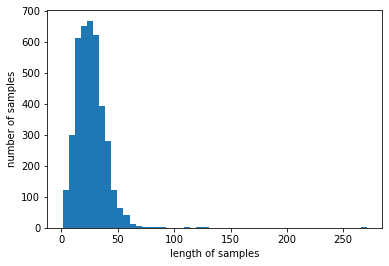

In [7]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프는 대부분의 샘플의 길이가 150 이내며 대부분 0~50의 길이를 가지는 것을 보여줍니다. 이제 케라스 토크나이저를 통해서 정수 인코딩을 진행합니다. 우선 케라스 토크나이저를 다음과 같이 함수로 구현합니다.

In [8]:
def tokenize(samples):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(samples)
  return tokenizer

문장 데이터에 대해서는 src_tokenizer를, 레이블에 해당되는 품사 태깅 정보에 대해서는 tar_tokenizer를 사용합니다.

In [9]:
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

단어 집합과 품사 태깅 정보 집합의 크기를 확인해보겠습니다.

In [10]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 11388
태깅 정보 집합의 크기 : 47


이제 정수 인코딩을 수행합니다.

In [11]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

이제 문장 데이터에 대해서 정수 인코딩이 수행된 결과는 X_train, 품사 태깅 데이터에 대해서 정수 인코딩이 수행된 결과는 y_train에 저장되었습니다. 정수 인코딩이 되었는지 확인을 위해 임의로 세번째 데이터를 출력해보겠습니다.

In [12]:
print(X_train[:2])
print(y_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


앞서 본 그래프에 따르면, 대부분의 샘플은 길이가 150 이내입니다. X에 해당되는 데이터 X_train의 샘플들과 y에 해당되는 데이터 y_train 샘플들의 모든 길이를 임의로 150정도로 맞추어 보겠습니다. 이를 위해서 케라스의 pad_sequences()를 사용합니다.

In [13]:
max_len = 150
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
# X_train의 모든 샘플의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)
# y_train의 모든 샘플의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.

모든 샘플의 길이가 150이 되었습니다. 이제 훈련 데이터와 테스트 데이터를 8:2의 비율로 분리합니다.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

레이블에 해당하는 태깅 정보에 대해서 원-핫 인코딩을 수행합니다.

In [15]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

이제 각 데이터에 대한 크기를 확인해보겠습니다.

In [16]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3131, 150)
훈련 샘플 레이블의 크기 : (3131, 150, 47)
테스트 샘플 문장의 크기 : (783, 150)
테스트 샘플 레이블의 크기 : (783, 150, 47)


### 2. 양방향 LSTM(Bi-directional LSTM)으로 POS Tagger 만들기

In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from keras.optimizers import Adam

In [18]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [19]:
model.fit(X_train, y_train, batch_size=128, epochs=6,  validation_data=(X_test, y_test))

Epoch 1/6
25/25 [==============================] - 12s 216ms/step - loss: 0.6098 - accuracy: 0.1323 - val_loss: 0.5073 - val_accuracy: 0.1630
Epoch 2/6
25/25 [==============================] - 2s 93ms/step - loss: 0.5051 - accuracy: 0.1741 - val_loss: 0.4677 - val_accuracy: 0.3104
Epoch 3/6
25/25 [==============================] - 2s 88ms/step - loss: 0.4460 - accuracy: 0.3739 - val_loss: 0.3405 - val_accuracy: 0.4891
Epoch 4/6
25/25 [==============================] - 2s 81ms/step - loss: 0.3077 - accuracy: 0.5488 - val_loss: 0.2026 - val_accuracy: 0.7024
Epoch 5/6
25/25 [==============================] - 2s 78ms/step - loss: 0.1735 - accuracy: 0.7633 - val_loss: 0.1088 - val_accuracy: 0.8517
Epoch 6/6
25/25 [==============================] - 2s 72ms/step - loss: 0.0839 - accuracy: 0.8973 - val_loss: 0.0676 - val_accuracy: 0.8993


In [20]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

25/25 [==============================] - 0s 19ms/step - loss: 0.0676 - accuracy: 0.8993

 테스트 정확도: 0.8993


실제로 맞추고 있는지를 특정 테스트 데이터를 주고 직접 출력해서 확인해보겠습니다. 우선 인덱스로부터 단어와 품사 태깅 정보를 리턴하는 index_to_word와 index_to_tag를 만들고 이를 이용하여 실제값과 예측값을 출력합니다.

In [21]:
index_to_word=src_tokenizer.index_word
index_to_tag=tar_tokenizer.index_word

i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_tag[t].upper(), index_to_tag[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
in               : IN      IN
addition         : NN      NN
,                : ,       ,
buick            : NNP     NNP
is               : VBZ     VBZ
a                : DT      DT
relatively       : RB      RB
respected        : VBN     VBN
nameplate        : NN      NN
among            : IN      IN
american         : NNP     NNP
express          : NNP     NNP
card             : NN      NN
holders          : NNS     NNS
,                : ,       ,
says             : VBZ     VBZ
0                : -NONE-  -NONE-
*t*-1            : -NONE-  -NONE-
an               : DT      DT
american         : NNP     NNP
express          : NNP     NNP
spokeswoman      : NN      NN
.                : .       .
